# Making slice plots (Advanced)

### Import packages

In [1]:
import numpy                          as np
import matplotlib.pyplot              as plt
import os

# importing plons modules
import plons
import plons.SmoothingKernelScript    as sk
import plons.PhysicalQuantities       as pq
import plons.ConversionFactors_cgs    as cgs
import plons.Plotting                 as plot

### Setting information about data

In [2]:
prefix = "wind"
loc = "Model"
dumpnumber = 600
dump = os.path.join(loc, f"{prefix}_{dumpnumber:06d}")

### Retrieving the data

Creating the directory to store the models

In [3]:
!mkdir -p $loc

Downloading the data

In [4]:
%%capture
if not os.path.exists(dump):
    !wget "https://github.com/Ensor-code/phantom-models/raw/refs/heads/main/Esseldeurs+2023/BinaryHighLucy/wind_00600?download=" --output-document $dump
infile = os.path.join(loc, f"{prefix}.in")
if not os.path.exists(infile):
    !wget "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Esseldeurs%2B2023/BinaryHighLucy/wind.in" --output-document $infile
setupfile = os.path.join(loc, f"{prefix}.setup")
if not os.path.exists(setupfile):
    !wget "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Esseldeurs%2B2023/BinaryHighLucy/wind.setup" --output-document $setupfile

### Loading setup and dump

In [5]:
setup     = plons.LoadSetup(loc, prefix)

In [6]:
dumpData  = plons.LoadFullDump(dump, setup)

### Making plane on which to smooth (as a meshgrid)

In [7]:
n = 200
x = np.linspace(-30, 30, n)*cgs.au
y = np.linspace(-30, 30, n)*cgs.au
X, Y = np.meshgrid(x, y)
Z    = np.zeros_like(X)

### Smoothing the data on the plane

In [8]:
smooth = sk.smoothMesh(X, Y, Z, dumpData, ['rho'])

### Plotting the plane

(<matplotlib.patches.Circle at 0x7f871b3f790>,
 <matplotlib.patches.Circle at 0x7f871cbb520>)

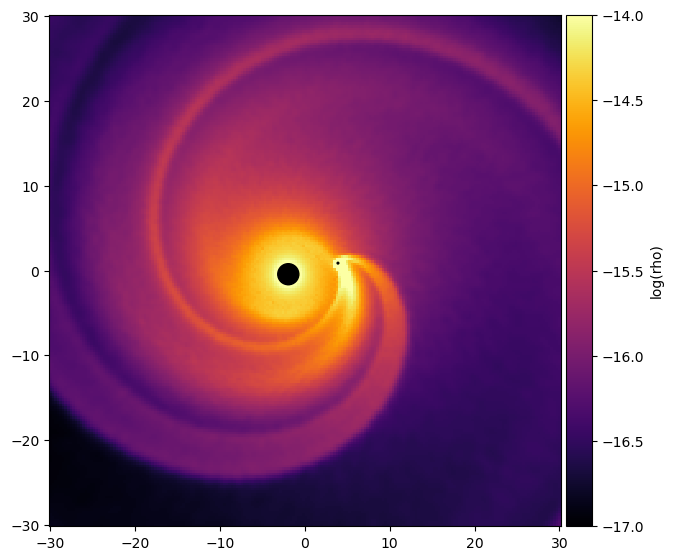

In [9]:
fig, ax = plt.subplots(1, figsize=(7, 7))
plot.plotSlice(ax, X, Y, smooth, 'rho', logplot=True, cmap = plt.colormaps['inferno'], clim=(-17, -14))
plot.plotSink(ax, dumpData, setup)

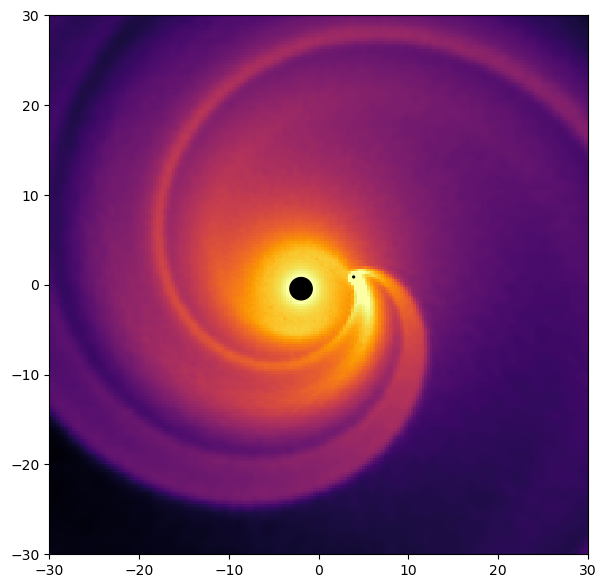

In [10]:
fig, ax = plt.subplots(1, figsize=(7, 7))

ax.set_aspect('equal')
ax.set_facecolor('k')

ax.pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth["rho"]+1e-99), cmap=plt.colormaps['inferno'], vmin=-17, vmax = -14)
ax.set_xlim(x[0]/cgs.au, x[-1]/cgs.au)
ax.set_ylim(y[0]/cgs.au, y[-1]/cgs.au)

circleAGB = plt.Circle(dumpData['posAGB']/cgs.au, setup["wind_inject_radius"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleAGB)
circleComp = plt.Circle(dumpData['posComp']/cgs.au, setup["rAccrComp"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleComp)

plt.show()

### Now smoothing the plane, but in a frame where the binary is located along the X-axis

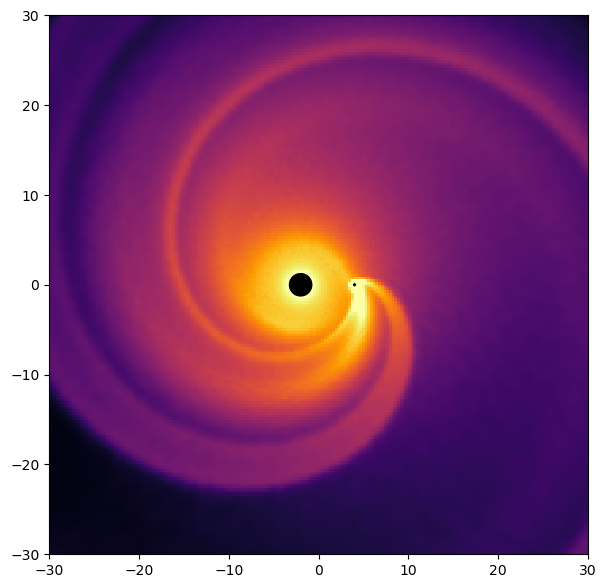

In [11]:
theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1]) # Calculate the angle around which to rotate
X_rot, Y_rot, Z_rot = sk.rotateMeshAroundZ(theta, X, Y, Z)                        # Rotate the mesh grid before computing the smoothed data. In this way the image will be constructed in the rotated frame
smooth_rot = sk.smoothMesh(X_rot, Y_rot, Z_rot, dumpData, ['rho'])                # Smooth the data with the rotated mesh

fig, ax = plt.subplots(1, figsize=(7, 7))

ax.set_aspect('equal')
ax.set_facecolor('k')

ax.pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth_rot["rho"]+1e-99), cmap=plt.colormaps['inferno'], vmin=-17, vmax = -14) # Use the unrotated mesh to plot the data, in this way the binary will show on the X-axis
ax.set_xlim(x[0]/cgs.au, x[-1]/cgs.au)
ax.set_ylim(y[0]/cgs.au, y[-1]/cgs.au)

circleAGB = plt.Circle((-np.linalg.norm(dumpData['posAGB'])/cgs.au, 0.), setup["wind_inject_radius"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleAGB)
circleComp = plt.Circle((np.linalg.norm(dumpData['posComp'])/cgs.au, 0.), setup["rAccrComp"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleComp)

plt.show()

### Adding arrows on the plot

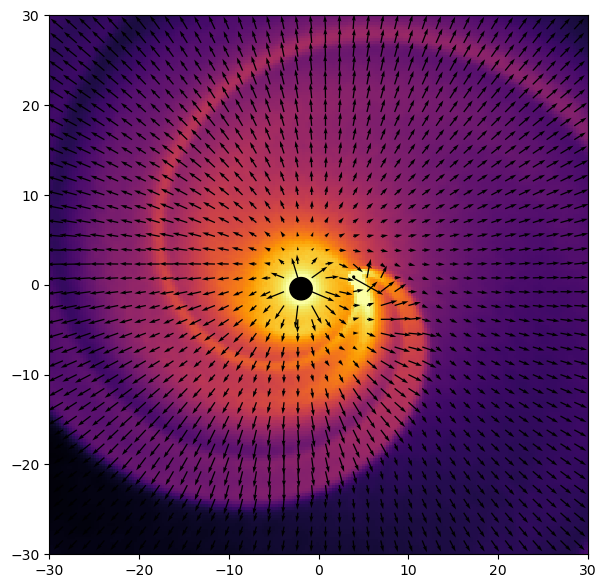

In [12]:
# Create a new mesh, with fewer points, as we want less velocity arrows than pixels on the figure
n_vec = 40
x_vec = np.linspace(-30, 30, n_vec)*cgs.au
y_vec = np.linspace(-30, 30, n_vec)*cgs.au
X_vec, Y_vec = np.meshgrid(x_vec, y_vec)
Z_vec    = np.zeros_like(X_vec)

smooth_vec = sk.smoothMesh(X_vec, Y_vec, Z_vec, dumpData, ['vx', 'vy', 'vz']) # smooth the velocities where we want to show the velocity arrows

normaliseVectorLength = 25.

fig, ax = plt.subplots(1, figsize=(7, 7))

ax.set_aspect('equal')
ax.set_facecolor('k')

ax.pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth["rho"]+1e-99), cmap=plt.colormaps['inferno'], vmin=-17, vmax = -14)
ax.set_xlim(x[0]/cgs.au, x[-1]/cgs.au)
ax.set_ylim(y[0]/cgs.au, y[-1]/cgs.au)

circleAGB = plt.Circle(dumpData['posAGB']/cgs.au, setup["wind_inject_radius"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleAGB)
circleComp = plt.Circle(dumpData['posComp']/cgs.au, setup["rAccrComp"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleComp)

ax.quiver(X_vec / cgs.au, Y_vec / cgs.au,
            smooth_vec['vx'] / normaliseVectorLength, smooth_vec['vy'] / normaliseVectorLength, scale_units="dots", scale=0.05)

plt.show()

### Adding arrows in the rotating frame

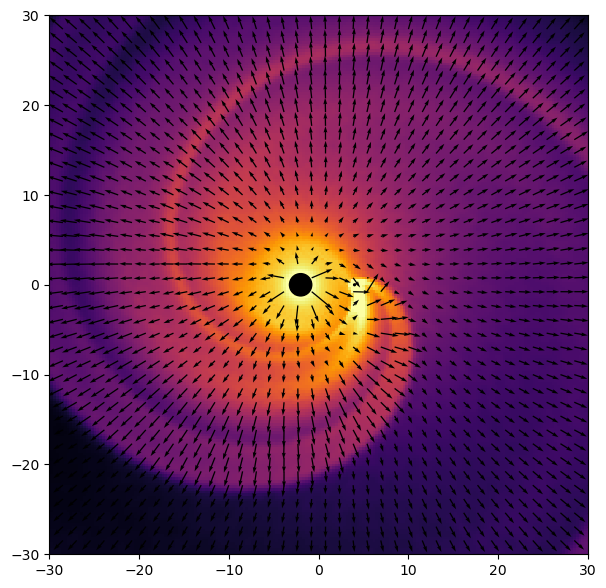

In [13]:
n_vec = 40
x_vec = np.linspace(-30, 30, n_vec)*cgs.au
y_vec = np.linspace(-30, 30, n_vec)*cgs.au
X_vec, Y_vec = np.meshgrid(x_vec, y_vec)
Z_vec    = np.zeros_like(X_vec)

theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])             # Calculate the angle around which to rotate
X_vec_rot, Y_vec_rot, Z_vec_rot = sk.rotateMeshAroundZ(theta, X_vec, Y_vec, Z_vec)            # Rotate the mesh grid before computing the smoothed data. In this way the image will be constructed in the rotated frame
smooth_vec_rot = sk.smoothMesh(X_vec_rot, Y_vec_rot, Z_vec_rot, dumpData, ['vx', 'vy', 'vz']) # smooth the velocities where we want to show the velocity arrows
smooth_vec_rot = sk.rotateVelocityAroundZ(-theta, smooth_vec_rot)                             # vx, vy and vz are now calculated in the frame of the simulation. They thus need to be rotated back to the frame where the binary is on the X-axis

normaliseVectorLength = 25.

fig, ax = plt.subplots(1, figsize=(7, 7))

ax.set_aspect('equal')
ax.set_facecolor('k')

ax.pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth_rot["rho"]+1e-99), cmap=plt.colormaps['inferno'], vmin=-17, vmax = -14)
ax.set_xlim(x[0]/cgs.au, x[-1]/cgs.au)
ax.set_ylim(y[0]/cgs.au, y[-1]/cgs.au)

circleAGB = plt.Circle((-np.linalg.norm(dumpData['posAGB'])/cgs.au, 0.), setup["wind_inject_radius"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleAGB)
circleComp = plt.Circle((np.linalg.norm(dumpData['posComp'])/cgs.au, 0.), setup["rAccrComp"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleComp)

ax.quiver(X_vec / cgs.au, Y_vec / cgs.au,
            smooth_vec_rot['vx'] / normaliseVectorLength, smooth_vec_rot['vy'] / normaliseVectorLength, scale_units="dots", scale=0.05)

plt.show()

### Zooming in around the companion

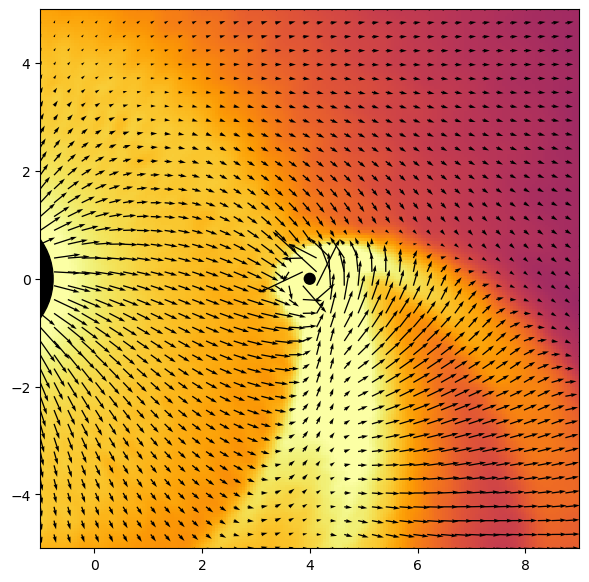

In [14]:
n = 200
x_comp = np.linspace(-5*cgs.au+np.linalg.norm(dumpData['posComp']), 5*cgs.au+np.linalg.norm(dumpData['posComp']), n)
y_comp = np.linspace(-5, 5, n)*cgs.au
X_comp, Y_comp = np.meshgrid(x_comp, y_comp)
Z_comp    = np.zeros_like(X_comp)

theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])
X_rot_comp, Y_rot_comp, Z_rot_comp = sk.rotateMeshAroundZ(theta, X_comp, Y_comp, Z_comp)
smooth_rot_comp = sk.smoothMesh(X_rot_comp, Y_rot_comp, Z_rot_comp, dumpData, ['rho'])

n_vec = 40
x_vec_comp = np.linspace(-5*cgs.au+np.linalg.norm(dumpData['posComp']), 5*cgs.au+np.linalg.norm(dumpData['posComp']), n_vec)
y_vec_comp = np.linspace(-5*cgs.au, 5*cgs.au, n_vec)
X_vec_comp, Y_vec_comp = np.meshgrid(x_vec_comp, y_vec_comp)
Z_vec_comp    = np.zeros_like(X_vec_comp)

theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])
X_vec_rot_comp, Y_vec_rot_comp, Z_vec_rot_comp = sk.rotateMeshAroundZ(theta, X_vec_comp, Y_vec_comp, Z_vec_comp)
smooth_vec_rot_comp = sk.smoothMesh(X_vec_rot_comp, Y_vec_rot_comp, Z_vec_rot_comp, dumpData, ['vx', 'vy', 'vz'])
smooth_vec_rot_comp = sk.rotateVelocityAroundZ(-theta, smooth_vec_rot_comp)

normaliseVectorLength = 25.

fig, ax = plt.subplots(1, figsize=(7, 7))

ax.set_aspect('equal')
ax.set_facecolor('k')

ax.pcolormesh(X_comp/cgs.au, Y_comp/cgs.au, np.log10(smooth_rot_comp["rho"]+1e-99), cmap=plt.colormaps['inferno'], vmin=-17, vmax = -14)
ax.set_xlim(x_comp[0]/cgs.au, x_comp[-1]/cgs.au)
ax.set_ylim(y_comp[0]/cgs.au, y_comp[-1]/cgs.au)

circleAGB = plt.Circle((-np.linalg.norm(dumpData['posAGB'])/cgs.au, 0.), setup["wind_inject_radius"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleAGB)
circleComp = plt.Circle((np.linalg.norm(dumpData['posComp'])/cgs.au, 0.), setup["rAccrComp"], transform=ax.transData._b, color="black", zorder=10)
ax.add_artist(circleComp)

ax.quiver(X_vec_comp / cgs.au, Y_vec_comp / cgs.au,
            smooth_vec_rot_comp['vx'] / normaliseVectorLength, smooth_vec_rot_comp['vy'] / normaliseVectorLength, scale_units="dots", scale=0.05)

plt.show()

### Recreating figure 6 of Esseldeurs et al. (2023)

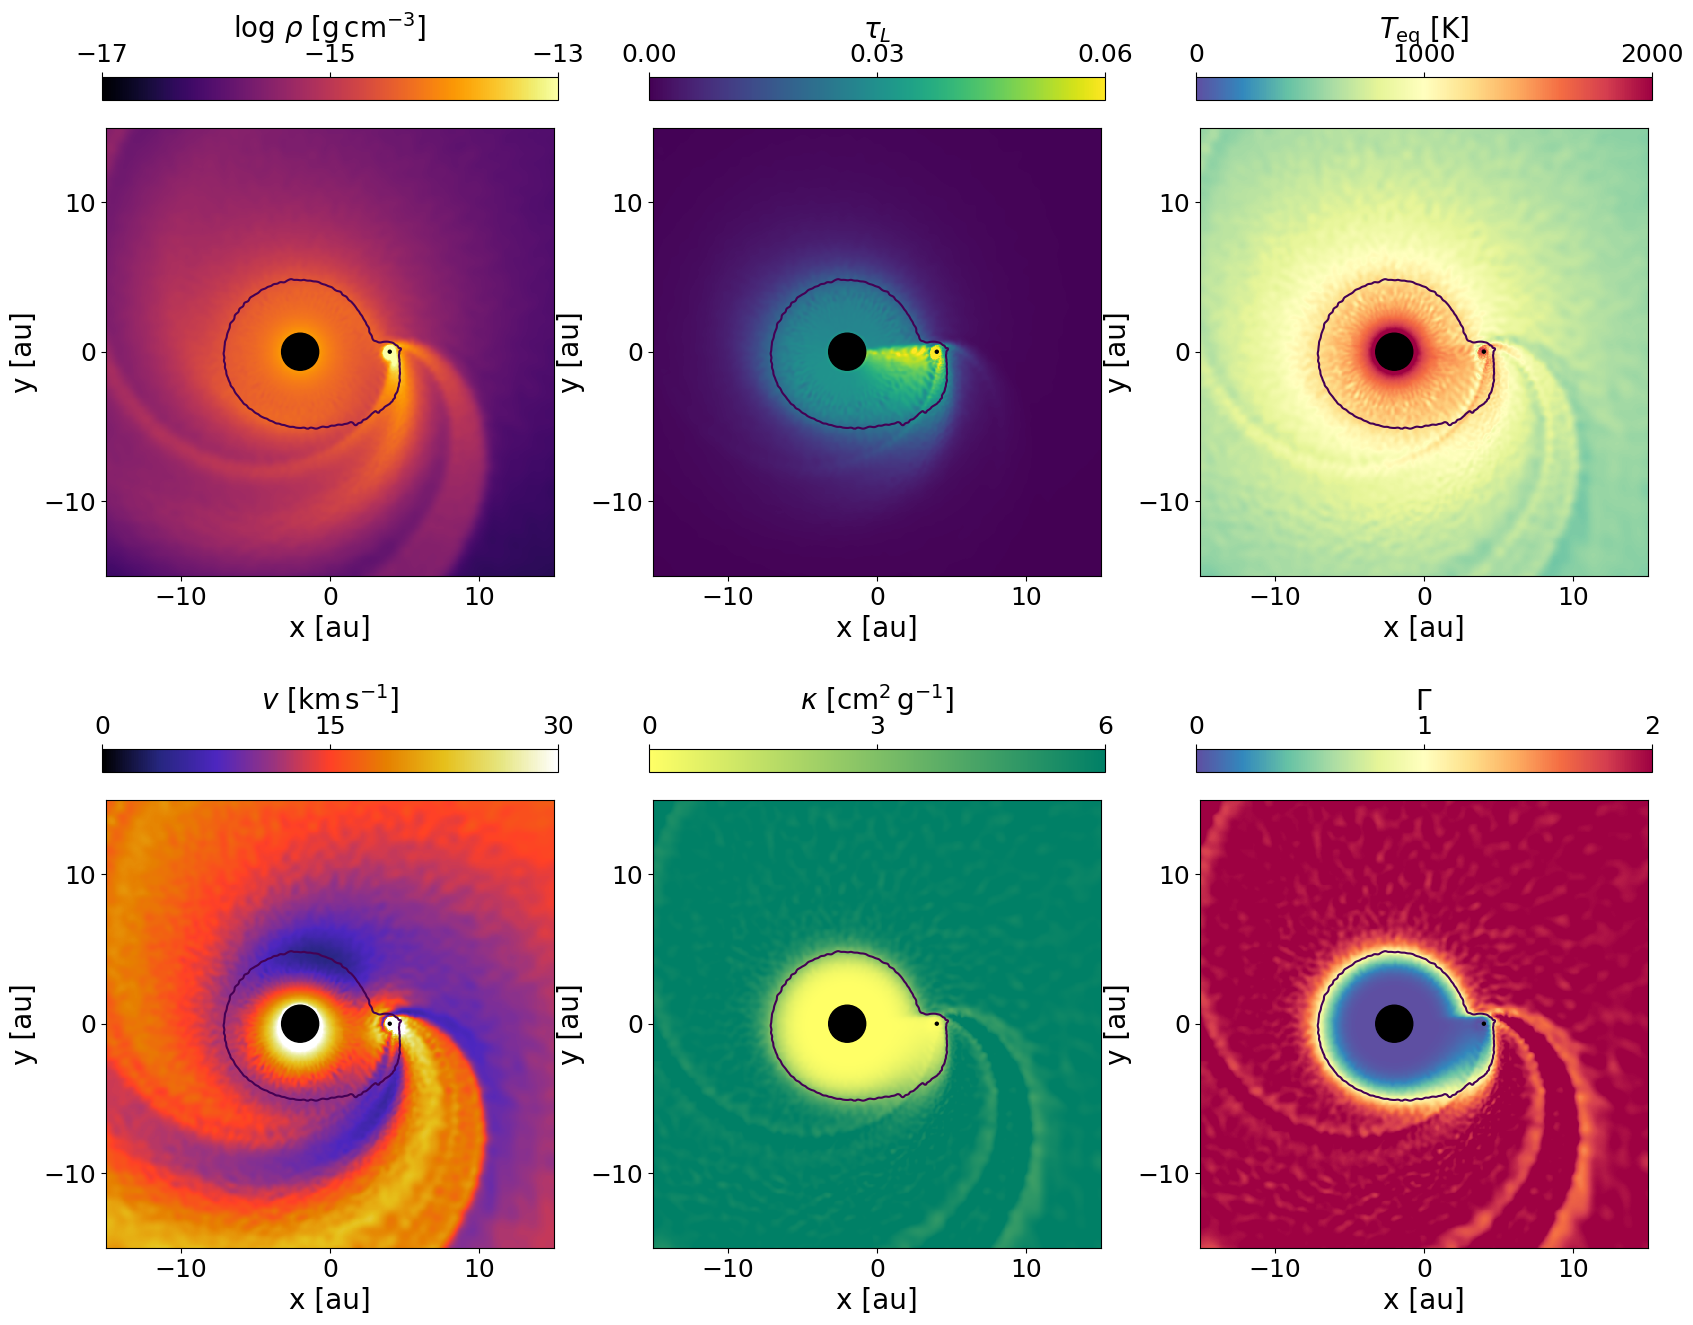

In [ ]:
n = 500
x = np.linspace(-15, 15, n)*cgs.au
y = np.linspace(-15, 15, n)*cgs.au
X, Y = np.meshgrid(x, y)
Z    = np.zeros_like(X)

observables = ['rho', "tauL", "Tdust", "speed", "kappa", "Gamma"]
logscale = [True, False, False, False, False, False]
cmaps = ['inferno', 'viridis', 'Spectral_r', 'CMRmap', 'summer_r', 'Spectral_r']
labels = [r'$\log \, \rho$ [g$\,$cm$^{-3}$]', r'$\tau_L$', r'$T_{\rm eq}$ [K]', r'$v$ [km$\,$s$^{-1}$]', r'$\kappa$ [cm$^{2}\,$g$^{-1}$]', r'$\Gamma$']
ticks = [[-17, -15, -13], [0, 0.03, 0.06], [0, 1000, 2000], [0, 15, 30], [0, 3, 6], [0, 1, 2]]

theta = pq.getPolarAngleCompanion(dumpData['posComp'][0], dumpData['posComp'][1])
X_rot, Y_rot, Z_rot = sk.rotateMeshAroundZ(theta, X, Y, Z)
smooth_rot = sk.smoothMesh(X_rot, Y_rot, Z_rot, dumpData, observables)

fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax = np.hstack((ax[0], ax[1]))

for i in range(len(ax)):
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].set_facecolor('k')
    ax[i].set_xlim(-15, 15)
    ax[i].set_ylim(-15, 15)
    ax[i].tick_params(labelsize=18)
    ax[i].set_xticks([-10, 0, 10])
    ax[i].set_yticks([-10, 0, 10])
    ax[i].set_xlabel('x [au]', fontsize=20)
    ax[i].set_ylabel('y [au]', fontsize=20)

    if logscale[i]:
        axPlot = ax[i].pcolormesh(X/cgs.au, Y/cgs.au, np.log10(smooth_rot[observables[i]]+1e-99), cmap=plt.colormaps[cmaps[i]], vmin=ticks[i][0], vmax = ticks[i][-1])
    else:
        axPlot = ax[i].pcolormesh(X/cgs.au, Y/cgs.au, smooth_rot[observables[i]], cmap=plt.colormaps[cmaps[i]], vmin=ticks[i][0], vmax = ticks[i][-1])
    cbar = fig.colorbar(axPlot, ax = ax[i], location='top')
    cbar.set_label(labels[i], fontsize=20)
    cbar.set_ticks(ticks[i])
    cbar.ax.tick_params(labelsize=18)
    ax[i].contour(X/cgs.au, Y/cgs.au, smooth_rot["kappa"], [3])
    
    circleAGB = plt.Circle((-np.linalg.norm(dumpData['posAGB'])/cgs.au, 0.), setup["wind_inject_radius"], transform=ax[i].transData._b, color="black", zorder=10)
    ax[i].add_artist(circleAGB)
    circleComp = plt.Circle((np.linalg.norm(dumpData['posComp'])/cgs.au, 0.), setup["rAccrComp"], transform=ax[i].transData._b, color="black", zorder=10)
    ax[i].add_artist(circleComp)

plt.tight_layout
plt.show()